<h1> Week 6 Homework

<h2>Question 9.1</h2>

Using the same crime data set uscrime.txt as in Question 8.2, apply Principal Component Analysis and then create a regression model using the first few principal components. 

Specify your new model in terms of the original variables (not the principal components), and compare its quality to that of your solution to Question 8.2. 

You can use the R function prcomp for PCA. (Note that to first scale the data, you can include scale. = TRUE to scale as part of the PCA function. Don’t forget that, to make a prediction for the new city, you’ll need to unscale the coefficients (i.e., do the scaling calculation in reverse)!) 

In [1]:
# loading the dataset
# READ DATASET as DataFrame
df <- read.table("uscrime.txt", header = TRUE, sep = "\t")
# Display Data
head(df)
cat("No. of cols:", ncol(df), "\n")
cat("No. of rows:", nrow(df))

,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
2,14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
3,14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
4,13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
5,14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
6,12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682


No. of cols: 16 
No. of rows: 47

<p><p style="page-break-after:always;"></p></p>

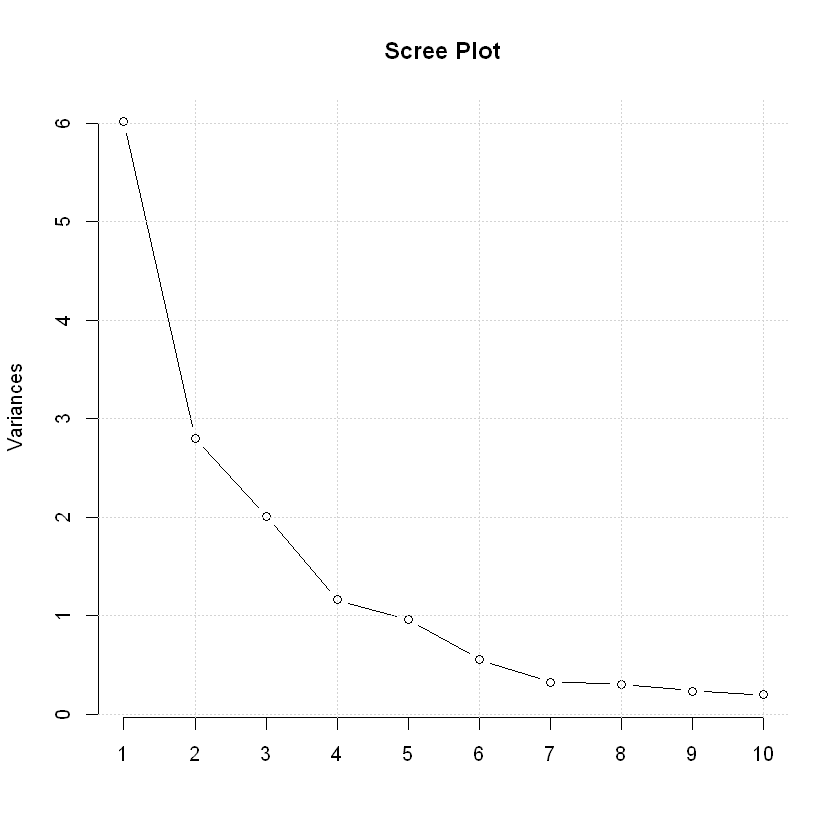

In [2]:
# Prepare predictors df
input_df <- df[,1:(ncol(df)-1)]
# Principal Component Analysis
PCA <- prcomp(input_df, scale=TRUE, center=TRUE)
# Scree Plot
screeplot(PCA, main="Scree Plot", type="l")
grid()

<p><p style="page-break-after:always;"></p></p>

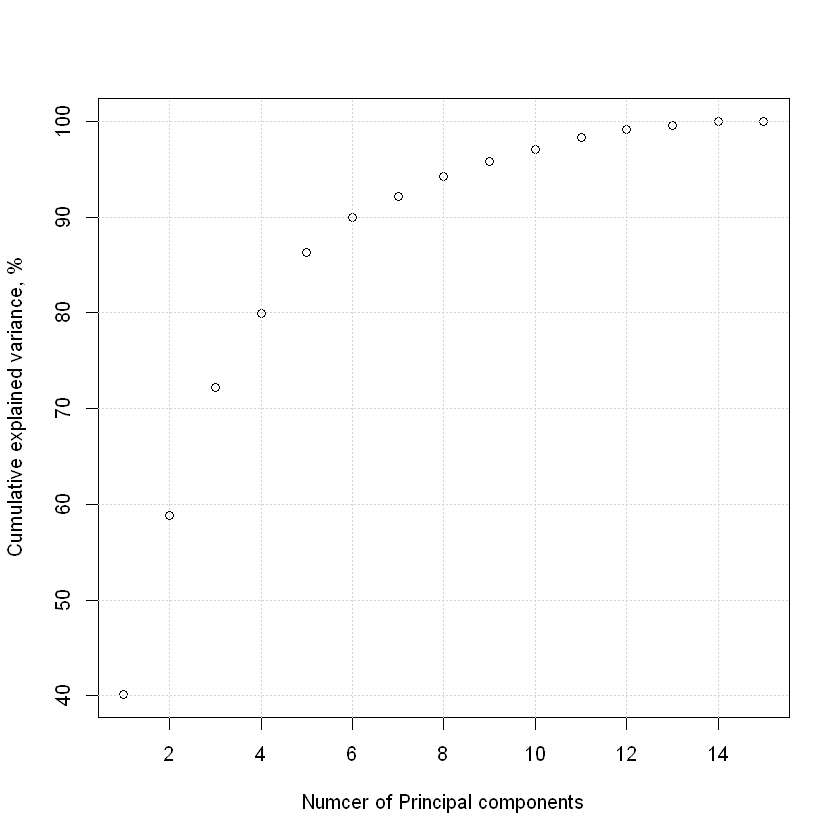

In [3]:
# plot Cumulative explained Varinace aganist number of principal components
plot(summary(PCA)$importance["Cumulative Proportion",]*100,
     ylab="Cumulative explained variance, %", xlab="Numcer of Principal components")
grid()

From the Scree plot and the cumulative explained variance plot above, the first 6 principal components explains 90% of the cumulative variance in the data and shows leveling off "elbow effect" on the Scree plot.

As a result, the first 6 principal components are expected to show the best performance.

However a sensitivity analysis will be done by comparing the Adjusted R2 of different linear regression models utilizing different numbers of principal components (PC's) starting with first 3 PC's up to all 15 PC's.

<p><p style="page-break-after:always;"></p></p>

In [4]:
# Install the DAAG package, which has cross-validation functions
options(warn=-1) # hide warning
# install.packages("DAAG")
library(DAAG)

Loading required package: lattice


In [ ]:
# Vectors to stor Results
adjR2_results <- seq(1,13)
CV_adjR2_results <- seq(1,13)

# loop for different PCs'
for (i in seq(1,13)){
    # define number of PCs'
    n_PCA = i+2
    # extract principal components for linear regression
    input_df <- as.data.frame(PCA$x[,1:n_PCA])
    # Add Crime column to the input dataframe
    input_df$Crime <- df$Crime
    # create the model
    sen_model <- lm(Crime~., data=input_df)
    # Store training Adjusted R2
    adjR2_results[i] <- summary(sen_model)$adj.r.squared
    # do 5-fold cross-validation
    sen_cv_results <- cv.lm(input_df,sen_model,m=5, printit=TRUE, plotit=FALSE)
    # total sum of squared differences between data and its mean (SSE Total)
    SStot <- sum((input_df$Crime - mean(input_df$Crime))^2)
    # Calculate mean squared error, times number of data points, gives sum of squared errors
    SSres_cv <- attr(sen_cv_results,"ms")*nrow(input_df)
    # Calculate CV R squared 
    CV_R2 <- (1 - SSres_cv/SStot)
    # Caluclate CV Adjusted R2
    CV_R2_Adj <- 1-(((1-CV_R2)*(nrow(input_df)))/(nrow(input_df)-n_PCA-1))
    # Store results
    CV_adjR2_results[i] <- CV_R2_Adj
}

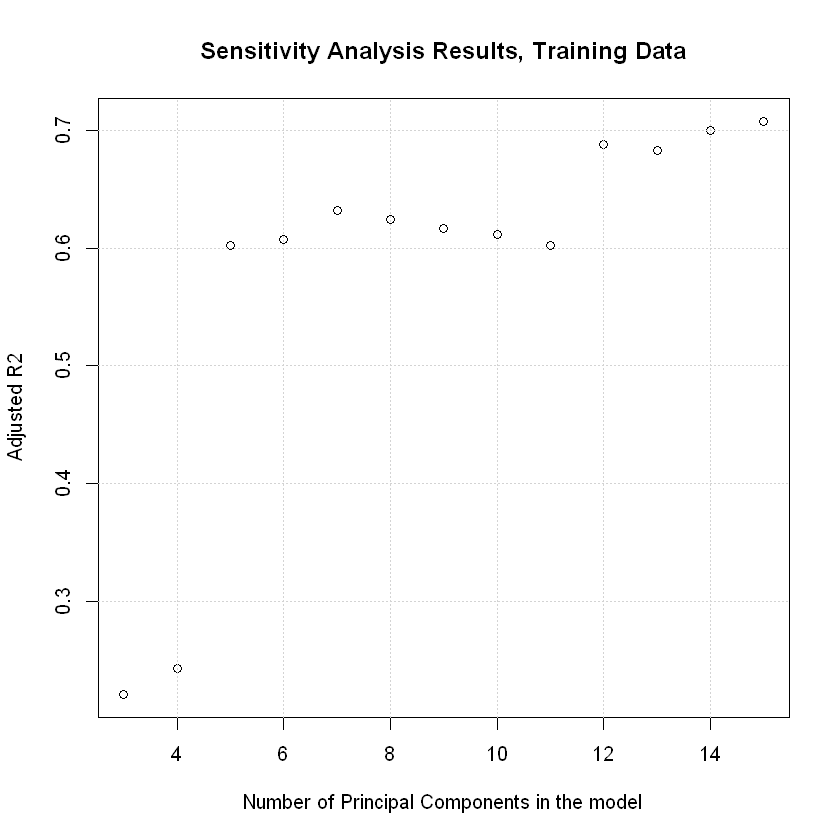

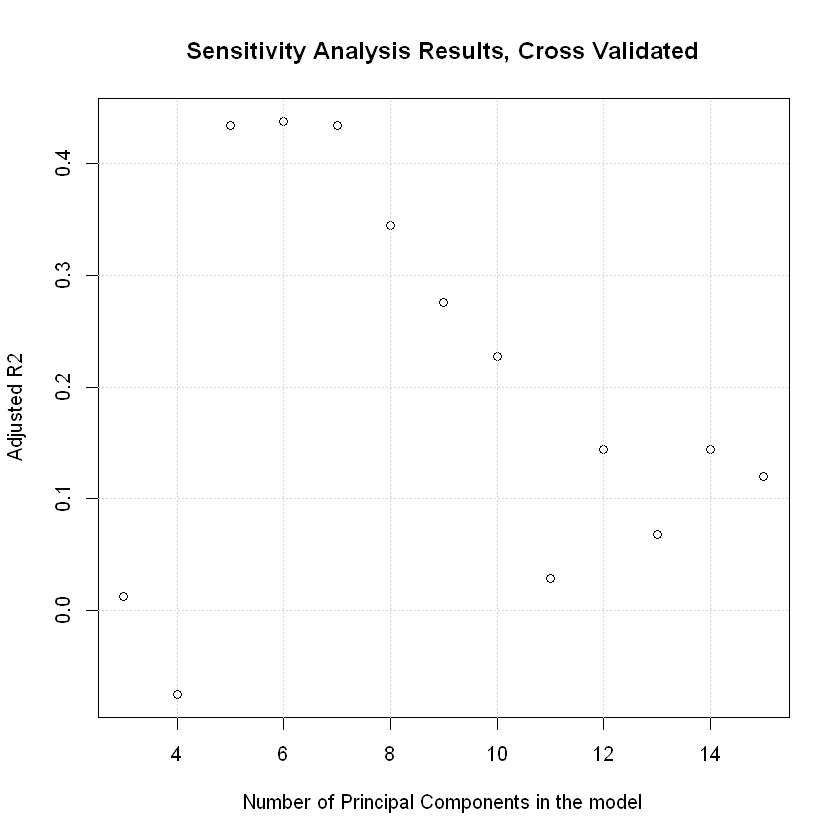

In [6]:
plot(seq(3,15), adjR2_results, xlab="Number of Principal Components in the model", ylab="Adjusted R2")
title("Sensitivity Analysis Results, Training Data")
grid()
plot(seq(3,15), CV_adjR2_results, xlab="Number of Principal Components in the model", ylab="Adjusted R2")
title("Sensitivity Analysis Results, Cross Validated")
grid()

From the Sensitivity analyis above, 
1. Using the first 5 PCs' up to using the first 11 PCs' results in roughly the same Adjusted R2 when evaluated on the training data. In addition, a jump in R2 from 0.6 to 0.7 is noticed when the model is built using the first 12 PCs' and more.
2. Cross-Validation however, shows that using more than the first 7 PCs' results in a drop in the Adjusted R2.
3. Also from Cross-Validation, using the first 5 PCs' up to using the first 7 PCs' results in roughly the same Adjusted R2.

As a result, the simplest model (using the first 5 PCs') will be used for the rest of the analysis.

<p><p style="page-break-after:always;"></p></p>

In [7]:
n_PCA = 5
# extract principal components for linear regression
input_df <- as.data.frame(PCA$x[,1:n_PCA])
# Add Crime column to the input dataframe
input_df$Crime <- df$Crime
# create the model
Final_model <- lm(Crime~., data=input_df)
summary(Final_model)


Call:
lm(formula = Crime ~ ., data = input_df)

Residuals:
   Min     1Q Median     3Q    Max 
-420.8 -185.0   12.2  146.2  447.9 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    905.1       35.6   25.43  < 2e-16 ***
PC1             65.2       14.7    4.45  6.5e-05 ***
PC2            -70.1       21.5   -3.26   0.0022 ** 
PC3             25.2       25.4    0.99   0.3272    
PC4             69.4       33.4    2.08   0.0437 *  
PC5           -229.0       36.8   -6.23  2.0e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 244 on 41 degrees of freedom
Multiple R-squared:  0.645,	Adjusted R-squared:  0.602 
F-statistic: 14.9 on 5 and 41 DF,  p-value: 2.45e-08


From the data above, The R2 of the 5 PC's model is 0.645 and adjusted R2 is 0.602 on evaluating on the training data.

Now, we can validate the model with 5 folds cross validation.

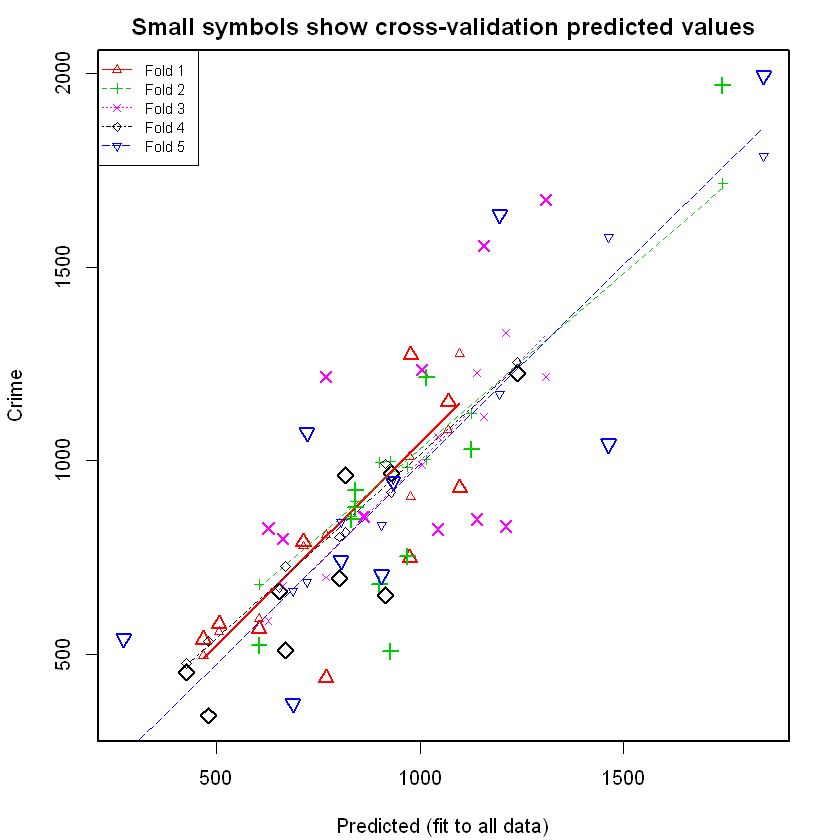

In [8]:
# do 5-fold cross-validation
cv_results <- cv.lm(input_df,Final_model,m=5, printit=FALSE)

In [9]:
# total sum of squared differences between data and its mean (SSE Total)
SStot <- sum((input_df$Crime - mean(input_df$Crime))^2)
# Calculate mean squared error, times number of data points, gives sum of squared errors
SSres_cv <- attr(cv_results,"ms")*nrow(input_df)
# Calculate R squared 
CV_R2 <- (1 - SSres_cv/SStot)
cat("Cross-Validated R2 of the Final PCA Model", round(CV_R2,3), "\n")
CV_R2_Adj <- 1-(((1-CV_R2)*(nrow(input_df)))/(nrow(input_df)-n_PCA-1))
cat("Cross-Validated Adjusted R2 of the Final PCA Model", round(CV_R2_Adj,3))

Cross-Validated R2 of the Final PCA Model 0.507 
Cross-Validated Adjusted R2 of the Final PCA Model 0.435

The cross validated R2 is lower than the R2 evaluated by the model on the training set indciating overfitting.

<p><p style="page-break-after:always;"></p></p>

In [10]:
"Coefficients of the PCA Model"
# find the model intercept a0
a0 <- Final_model$coefficients[1]
round(a0,3)
# find model coefficients
coff <- Final_model$coefficients[2:(n_PCA+1)]
round(coff,3)

[1] "Coefficients of the PCA Model"

(Intercept) 
        905

PC1    PC2    PC3    PC4    PC5 
  65.2  -70.1   25.2   69.4 -229.0

In [11]:
# find Dataframe Columns mean & Sd
cols_mu <- colMeans(df[,1:(ncol(df)-1)])
cols_sd <- sapply(df[,1:(ncol(df)-1)], sd)

In [12]:
"The new model coefficients and intercept in terms of the original variables"
transformed_coeff <- PCA$rotation[,1:n_PCA] %*% coff
# find original variables coffcients
original_coff <- t(transformed_coeff)/cols_sd
round(original_coff,3)
# find original variables intercept
original_a0 <- a0 - sum(transformed_coeff*cols_mu/cols_sd)
round(original_a0, 3)

[1] "The new model coefficients and intercept in terms of the original variables"

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time
48.4,79,17.8,39.5,39.9,1887,36.7,1.55,9.54,159,38.3,0.037,5.54,-1524,3.84


(Intercept) 
      -5934

<b> Note: </b> Since only 5 prinicipal components were used out of the 15, the reverse calculated coefficients and intercept carries some reconstruction error.

<p><p style="page-break-after:always;"></p></p>

"New City Prediciton"

In [13]:
# creating required test city data
test_city <- data.frame("M"=14.0, "So"=0, "Ed"=10.0, "Po1"=12.0, "Po2"=15.5, "LF"=0.64, "M.F"=94.0, "Pop"=150, "NW"=1.1,
                       "U1"=0.12, "U2"=3.6, "Wealth"=3200, "Ineq"=20.1, "Prob"=0.04, "Time"=39.0)
test_city

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,0,10,12,15.5,0.64,94,150,1.1,0.12,3.6,3200,20.1,0.04,39


In [14]:
# Find the principal components of the test city 
test_city_PCA <- as.data.frame(predict(PCA, test_city[,1:(ncol(df)-1)]))
# Predict the crime rate in the test city
test_city_pred <- round(predict(Final_model, test_city_PCA, type = "response", 
                                interval="prediction", level=0.95), 0)
cat("Predicted Crime rate for the new city is", test_city_pred[,"fit"], "\n")
# calculate confidence
cat("Predicted Crime rate the new city is between", test_city_pred[,"lwr"],
    "&", test_city_pred[,"upr"], "with 95% confidence")

Predicted Crime rate for the new city is 1389 
Predicted Crime rate the new city is between 861 & 1917 with 95% confidence

<p><p style="page-break-after:always;"></p></p>

<b> Conclusions: </b>

Comparing the PCA based model with the Linear regression model of last week's assignment, 
1. The prediction for the new city from the PCA model is 1,389 crime/100,000 population as compared to 1,304 from the linear 6 factors regression model.(very close results)
2. A sensitivity analysis showed that using the first 5, 6 or 7 Principal components in the model will result in roughly the same cross-validated model accuracy. As a result, the simplest model (using the first 5 PC's) was used.
2. Compairson between the 5 PC's linear regression model vs. the 6 factor linear regression model is shown in the table below.

| Model | R2 directly evaluated on training set | Adjusted R2 directly evaluated on training set | R2 cross-validated | Adjusted R2 cross-validated |
| --- | --- | --- | --- | --- |
| 6-factor Linear Model | 0.766 | 0.731 | 0.638 | 0.584 |
| 5 PC's Linear Model | 0.645 | 0.602 | 0.507 | 0.435 |

From the table, 
1. For Both models, cross-validated R2 is lower than R2 evaluated on training data indicating overfitting by the models. This is due to the limited dataset as it has just 47 data points and 15 factors, a ratio of about 3:1, and it’s usually good to have a ratio of 10:1 or more.
2. The 6-factor linear regression Model is better performing than the 5 principal components' model on training data and on cross-validation.
3. The reason why PCA performs poorer than the linear regression model can be attributed to the PCA capturing noise within several of the higher-rated (First) PCs. PCA prioritizes features by their total variance, aiming to capture the most variance in the dataset as efficiently as it can. However, more variance doesn't necessarily mean more correlation with the dependent variable, it could be attributed to more noise in the variable.